In [21]:
import logging
from itertools import combinations_with_replacement
from typing import Any, Dict, List

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, VotingClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
import matplotlib.pyplot as plt

from nba_betting.logging.tools import logger
from nba_betting.model.classes import NBA_MODELS
from nba_betting.model.training import preprocess_games
from nba_betting.model.unsupervised_ensemble import UnsupervisedEnsemble
from nba_betting.analysis.visualization import plot_conf_mat


# Hide DEBUG logging statements
logger.setLevel(logging.INFO)

# Test the performance of the ensemble on limited portions of the dataset

In [22]:
# Create the test set and stratify across games played for evaluation
TRAIN_YEAR = 2018
TEST_YEAR = 2019
X_test, y_test = preprocess_games(TEST_YEAR)


split_X_y_dfs = dict()
for i, row in X_test.iterrows():
    assert isinstance(i, int)
    games_played = int(row["GAMES_PLAYED"])
    row_games_played_interval = (
        10 * int(games_played / 10),
        ((10 * (1 + int(games_played / 10))) - 1),
    )

    if row_games_played_interval not in split_X_y_dfs:
        split_X_y_dfs[row_games_played_interval] = (
            pd.DataFrame(columns=X_test.columns),
            pd.Series(dtype=str),
        )

    split_X_y_dfs[row_games_played_interval][0].loc[i, :] = row
    split_X_y_dfs[row_games_played_interval][1].loc[i] = y_test.iloc[i]

INFO:nba_betting:Processing data for year 2019
INFO:nba_betting:Ignoring rows with under 0 games played.
INFO:root:Getting game data...
INFO:root:Creating matchups...
INFO:root:Done creating matchups.
INFO:nba_betting:Retrieved data for year 2019.
Columns: Index(['level_0', 'index', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'GAMES_PLAYED', 'ALLOWED_PTS',
       'ALLOWED_FGM', 'ALLOWED_FGA', 'ALLOWED_FG_PCT', 'ALLOWED_FG3M',
       'ALLOWED_FG3A', 'ALLOWED_FG3_PCT', 'ALLOWED_FTM', 'ALLOWED_FTA',
       'ALLOWED_FT_PCT', 'ALLOWED_OREB', 'ALLOWED_DREB', 'ALLOWED_REB',
       'ALLOWED_AST', 'ALLOWED_STL', 'ALLOWED_BLK', 'ALLOWED_TOV',
       'ALLOWED_PF', 'ALLOWED_PLUS_MINUS', 'ALLOWED_GAMES_PLAYED', 'OPP_PTS',
       'OPP_FGM', 'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M', 'OPP_FG3A',
       'OPP_FG3_PCT', 'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT', 'OPP_OREB',
       'OPP_DREB', 'O

In [23]:
random_forest_params = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [1, 2, 3],
    "ccp_alpha": [0, 0.05, 0.1],
}

def train_unsupervised_ensemble(X_train, y_train):
    logger.info(
        "Training UnsupervisedEnsemble with: %r", [model_name for model_name in NBA_MODELS]
    )

    logging.info(
        "Using RandomForestRegressor for correction and weights models"
    )
    unsupervised_ensemble = UnsupervisedEnsemble(
        models=[_() for _ in NBA_MODELS.values()],
        correction_learner=GridSearchCV(
            estimator=RandomForestRegressor(),
            cv=3,
            param_grid=random_forest_params,
            n_jobs=4,
        ),
        weight_learner=GridSearchCV(
            estimator=RandomForestRegressor(),
            cv=3,
            param_grid=random_forest_params,
            n_jobs=4,
        ),
    )
    unsupervised_ensemble.fit(X_train, y_train)
    return unsupervised_ensemble


In [24]:
def train_voting_cls(X_train, y_train):
    voting_cls = VotingClassifier(
        estimators=[(model_name, model()) for model_name, model in NBA_MODELS.items()],
        voting="soft",
    )
    voting_cls = voting_cls.fit(X_train, y_train)
    return voting_cls


## Test on all games

In [25]:
X_train_0, y_train_0 = preprocess_games(TRAIN_YEAR, min_games_played=0)

INFO:nba_betting:Processing data for year 2018
INFO:nba_betting:Ignoring rows with under 0 games played.
INFO:root:Getting game data...
INFO:root:Creating matchups...
INFO:root:Done creating matchups.
INFO:nba_betting:Retrieved data for year 2018.
Columns: Index(['level_0', 'index', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'GAMES_PLAYED', 'ALLOWED_PTS',
       'ALLOWED_FGM', 'ALLOWED_FGA', 'ALLOWED_FG_PCT', 'ALLOWED_FG3M',
       'ALLOWED_FG3A', 'ALLOWED_FG3_PCT', 'ALLOWED_FTM', 'ALLOWED_FTA',
       'ALLOWED_FT_PCT', 'ALLOWED_OREB', 'ALLOWED_DREB', 'ALLOWED_REB',
       'ALLOWED_AST', 'ALLOWED_STL', 'ALLOWED_BLK', 'ALLOWED_TOV',
       'ALLOWED_PF', 'ALLOWED_PLUS_MINUS', 'ALLOWED_GAMES_PLAYED', 'OPP_PTS',
       'OPP_FGM', 'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M', 'OPP_FG3A',
       'OPP_FG3_PCT', 'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT', 'OPP_OREB',
       'OPP_DREB', 'O

In [26]:
ensemble_0 = train_unsupervised_ensemble(X_train_0, y_train_0)
voting_ensemble_0 = train_voting_cls(X_train_0, y_train_0)

logger.info(
    "correction model best params: %r",
    ensemble_0.correction_model.best_params_,
)
logger.info(
    "weight model best params: %r",
    ensemble_0.weight_learner.best_params_,
)

INFO:nba_betting:Training UnsupervisedEnsemble with: ['defence_logistic_regression', 'offence_logistic_regression', 'efficiency_logistic_regression', 'general_logistic_regression', 'shooting_logistic_regression', 'defence_gaussian_naive_bayes', 'offence_gaussian_naive_bayes', 'efficiency_gaussian_naive_bayes', 'general_gaussian_naive_bayes', 'defence_random_forest', 'offence_random_forest', 'efficiency_random_forest']
INFO:root:Using RandomForestRegressor for correction and weights models
/Users/Aaditya/git/ds4420_nba_betting/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


### Voting Classifier

In [42]:
print(
    f"Overall accuracy: {accuracy_score(y_test, voting_ensemble_0.predict(X_test))}"
)
print(classification_report(y_test, voting_ensemble_0.predict(X_test)))
print("==================================================")

for (min_games_played, max_games_played), (X_test_range, y_test_range) in split_X_y_dfs.items():
    print("==================================================")
    print(f"Metrics for games {min_games_played} to {max_games_played}")
    
    y_pred_range = voting_ensemble_0.predict(X_test_range)
    print(
        f"- range accuracy: {accuracy_score(y_test_range, y_pred_range)}",
    )
    print(classification_report(y_test_range, y_pred_range))

    print("==================================================")


Overall accuracy: 0.6251287332646756
              precision    recall  f1-score   support

           L       0.64      0.56      0.60       971
           W       0.61      0.69      0.65       971

    accuracy                           0.63      1942
   macro avg       0.63      0.63      0.62      1942
weighted avg       0.63      0.63      0.62      1942

Metrics for games 0 to 9
- range accuracy: 0.5833333333333334
              precision    recall  f1-score   support

           L       0.57      0.61      0.59       148
           W       0.59      0.56      0.58       152

    accuracy                           0.58       300
   macro avg       0.58      0.58      0.58       300
weighted avg       0.58      0.58      0.58       300

Metrics for games 10 to 19
- range accuracy: 0.7133333333333334
              precision    recall  f1-score   support

           L       0.76      0.63      0.69       153
           W       0.68      0.80      0.73       147

    accuracy       

### Aggregator Ensemble

In [41]:
print(
    f"Overall accuracy: {accuracy_score(y_test, ensemble_0.predict(X_test))}"
)
print(classification_report(y_test, ensemble_0.predict(X_test)))
print("==================================================")

for (min_games_played, max_games_played), (X_test_range, y_test_range) in split_X_y_dfs.items():
    print("==================================================")
    print(f"Metrics for games {min_games_played} to {max_games_played}")
    
    y_pred_range = ensemble_0.predict(X_test_range)
    print(
        f"- range accuracy: {accuracy_score(y_test_range, y_pred_range)}",
    )
    print(classification_report(y_test_range, y_pred_range))

    print("==================================================")


Overall accuracy: 0.6477857878475798
              precision    recall  f1-score   support

           L       0.65      0.63      0.64       971
           W       0.64      0.67      0.65       971

    accuracy                           0.65      1942
   macro avg       0.65      0.65      0.65      1942
weighted avg       0.65      0.65      0.65      1942

Metrics for games 0 to 9
- range accuracy: 0.6333333333333333
              precision    recall  f1-score   support

           L       0.64      0.59      0.62       148
           W       0.63      0.67      0.65       152

    accuracy                           0.63       300
   macro avg       0.63      0.63      0.63       300
weighted avg       0.63      0.63      0.63       300

Metrics for games 10 to 19
- range accuracy: 0.7166666666666667
              precision    recall  f1-score   support

           L       0.73      0.71      0.72       153
           W       0.71      0.72      0.71       147

    accuracy       

## Train without first 5 games

In [29]:
X_train_5, y_train_5 = preprocess_games(TRAIN_YEAR, min_games_played=5)

INFO:nba_betting:Processing data for year 2018
INFO:nba_betting:Ignoring rows with under 5 games played.
INFO:root:Getting game data...
INFO:root:Creating matchups...
INFO:root:Done creating matchups.
INFO:nba_betting:Retrieved data for year 2018.
Columns: Index(['level_0', 'index', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'GAMES_PLAYED', 'ALLOWED_PTS',
       'ALLOWED_FGM', 'ALLOWED_FGA', 'ALLOWED_FG_PCT', 'ALLOWED_FG3M',
       'ALLOWED_FG3A', 'ALLOWED_FG3_PCT', 'ALLOWED_FTM', 'ALLOWED_FTA',
       'ALLOWED_FT_PCT', 'ALLOWED_OREB', 'ALLOWED_DREB', 'ALLOWED_REB',
       'ALLOWED_AST', 'ALLOWED_STL', 'ALLOWED_BLK', 'ALLOWED_TOV',
       'ALLOWED_PF', 'ALLOWED_PLUS_MINUS', 'ALLOWED_GAMES_PLAYED', 'OPP_PTS',
       'OPP_FGM', 'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M', 'OPP_FG3A',
       'OPP_FG3_PCT', 'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT', 'OPP_OREB',
       'OPP_DREB', 'O

In [30]:
ensemble_5 = train_unsupervised_ensemble(X_train_5, y_train_5)
voting_ensemble_5 = train_voting_cls(X_train_5, y_train_5)

logger.info(
    "correction model best params: %r",
    ensemble_5.correction_model.best_params_,
)
logger.info(
    "weight model best params: %r",
    ensemble_5.weight_learner.best_params_,
)

INFO:nba_betting:Training UnsupervisedEnsemble with: ['defence_logistic_regression', 'offence_logistic_regression', 'efficiency_logistic_regression', 'general_logistic_regression', 'shooting_logistic_regression', 'defence_gaussian_naive_bayes', 'offence_gaussian_naive_bayes', 'efficiency_gaussian_naive_bayes', 'general_gaussian_naive_bayes', 'defence_random_forest', 'offence_random_forest', 'efficiency_random_forest']
INFO:root:Using RandomForestRegressor for correction and weights models
INFO:nba_betting:correction model best params: {'ccp_alpha': 0, 'max_depth': 3, 'n_estimators': 100}
INFO:nba_betting:weight model best params: {'ccp_alpha': 0, 'max_depth': 3, 'n_estimators': 100}


### Voting Classifier

In [43]:
print(
    f"Overall accuracy: {accuracy_score(y_test, voting_ensemble_5.predict(X_test))}"
)
print(classification_report(y_test, voting_ensemble_5.predict(X_test)))
print("==================================================")

for (min_games_played, max_games_played), (X_test_range, y_test_range) in split_X_y_dfs.items():
    print("==================================================")
    print(f"Metrics for games {min_games_played} to {max_games_played}")
    
    y_pred_range = voting_ensemble_5.predict(X_test_range)
    print(
        f"- range accuracy: {accuracy_score(y_test_range, y_pred_range)}",
    )
    print(classification_report(y_test_range, y_pred_range))

    print("==================================================")


Overall accuracy: 0.6055612770339855
              precision    recall  f1-score   support

           L       0.61      0.59      0.60       971
           W       0.60      0.62      0.61       971

    accuracy                           0.61      1942
   macro avg       0.61      0.61      0.61      1942
weighted avg       0.61      0.61      0.61      1942

Metrics for games 0 to 9
- range accuracy: 0.54
              precision    recall  f1-score   support

           L       0.53      0.57      0.55       148
           W       0.55      0.51      0.53       152

    accuracy                           0.54       300
   macro avg       0.54      0.54      0.54       300
weighted avg       0.54      0.54      0.54       300

Metrics for games 10 to 19
- range accuracy: 0.66
              precision    recall  f1-score   support

           L       0.68      0.63      0.66       153
           W       0.64      0.69      0.66       147

    accuracy                           0.66    

### Aggregator Ensemble

In [44]:
print(
    f"Overall accuracy: {accuracy_score(y_test, ensemble_5.predict(X_test))}"
)
print(classification_report(y_test, ensemble_5.predict(X_test)))
print("==================================================")

for (min_games_played, max_games_played), (X_test_range, y_test_range) in split_X_y_dfs.items():
    print("==================================================")
    print(f"Metrics for games {min_games_played} to {max_games_played}")
    
    y_pred_range = ensemble_5.predict(X_test_range)
    print(
        f"- range accuracy: {accuracy_score(y_test_range, y_pred_range)}",
    )
    print(classification_report(y_test_range, y_pred_range))

    print("==================================================")


Overall accuracy: 0.6194644696189495
              precision    recall  f1-score   support

           L       0.63      0.59      0.61       971
           W       0.61      0.65      0.63       971

    accuracy                           0.62      1942
   macro avg       0.62      0.62      0.62      1942
weighted avg       0.62      0.62      0.62      1942

Metrics for games 0 to 9
- range accuracy: 0.57
              precision    recall  f1-score   support

           L       0.58      0.49      0.53       148
           W       0.57      0.65      0.61       152

    accuracy                           0.57       300
   macro avg       0.57      0.57      0.57       300
weighted avg       0.57      0.57      0.57       300

Metrics for games 10 to 19
- range accuracy: 0.6766666666666666
              precision    recall  f1-score   support

           L       0.69      0.65      0.67       153
           W       0.66      0.70      0.68       147

    accuracy                     

## Train without first 10 games

In [33]:
X_train_10, y_train_10 = preprocess_games(TRAIN_YEAR, min_games_played=10)

INFO:nba_betting:Processing data for year 2018
INFO:nba_betting:Ignoring rows with under 10 games played.
INFO:root:Getting game data...
INFO:root:Creating matchups...
INFO:root:Done creating matchups.
INFO:nba_betting:Retrieved data for year 2018.
Columns: Index(['level_0', 'index', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'GAMES_PLAYED', 'ALLOWED_PTS',
       'ALLOWED_FGM', 'ALLOWED_FGA', 'ALLOWED_FG_PCT', 'ALLOWED_FG3M',
       'ALLOWED_FG3A', 'ALLOWED_FG3_PCT', 'ALLOWED_FTM', 'ALLOWED_FTA',
       'ALLOWED_FT_PCT', 'ALLOWED_OREB', 'ALLOWED_DREB', 'ALLOWED_REB',
       'ALLOWED_AST', 'ALLOWED_STL', 'ALLOWED_BLK', 'ALLOWED_TOV',
       'ALLOWED_PF', 'ALLOWED_PLUS_MINUS', 'ALLOWED_GAMES_PLAYED', 'OPP_PTS',
       'OPP_FGM', 'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M', 'OPP_FG3A',
       'OPP_FG3_PCT', 'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT', 'OPP_OREB',
       'OPP_DREB', '

In [34]:
ensemble_10 = train_unsupervised_ensemble(X_train_10, y_train_10)
voting_ensemble_10 = train_voting_cls(X_train_10, y_train_10)

logger.info(
    "correction model best params: %r",
    ensemble_10.correction_model.best_params_,
)
logger.info(
    "weight model best params: %r",
    ensemble_10.weight_learner.best_params_,
)

INFO:nba_betting:Training UnsupervisedEnsemble with: ['defence_logistic_regression', 'offence_logistic_regression', 'efficiency_logistic_regression', 'general_logistic_regression', 'shooting_logistic_regression', 'defence_gaussian_naive_bayes', 'offence_gaussian_naive_bayes', 'efficiency_gaussian_naive_bayes', 'general_gaussian_naive_bayes', 'defence_random_forest', 'offence_random_forest', 'efficiency_random_forest']
INFO:root:Using RandomForestRegressor for correction and weights models
/Users/Aaditya/git/ds4420_nba_betting/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


### Voting Classifier

In [45]:
print(
    f"Overall accuracy: {accuracy_score(y_test, voting_ensemble_10.predict(X_test))}"
)
print(classification_report(y_test, voting_ensemble_10.predict(X_test)))
print("==================================================")

for (min_games_played, max_games_played), (X_test_range, y_test_range) in split_X_y_dfs.items():
    print("==================================================")
    print(f"Metrics for games {min_games_played} to {max_games_played}")
    
    y_pred_range = voting_ensemble_10.predict(X_test_range)
    print(
        f"- range accuracy: {accuracy_score(y_test_range, y_pred_range)}",
    )
    print(classification_report(y_test_range, y_pred_range))

    print("==================================================")


Overall accuracy: 0.6040164778578785
              precision    recall  f1-score   support

           L       0.61      0.57      0.59       971
           W       0.60      0.64      0.62       971

    accuracy                           0.60      1942
   macro avg       0.60      0.60      0.60      1942
weighted avg       0.60      0.60      0.60      1942

Metrics for games 0 to 9
- range accuracy: 0.5566666666666666
              precision    recall  f1-score   support

           L       0.55      0.59      0.57       148
           W       0.57      0.52      0.54       152

    accuracy                           0.56       300
   macro avg       0.56      0.56      0.56       300
weighted avg       0.56      0.56      0.56       300

Metrics for games 10 to 19
- range accuracy: 0.6533333333333333
              precision    recall  f1-score   support

           L       0.67      0.62      0.65       153
           W       0.64      0.69      0.66       147

    accuracy       

### Aggregator Ensemble

In [46]:
print(
    f"Overall accuracy: {accuracy_score(y_test, ensemble_10.predict(X_test))}"
)
print(classification_report(y_test, ensemble_10.predict(X_test)))
print("==================================================")

for (min_games_played, max_games_played), (X_test_range, y_test_range) in split_X_y_dfs.items():
    print("==================================================")
    print(f"Metrics for games {min_games_played} to {max_games_played}")
    
    y_pred_range = ensemble_10.predict(X_test_range)
    print(
        f"- range accuracy: {accuracy_score(y_test_range, y_pred_range)}",
    )
    print(classification_report(y_test_range, y_pred_range))

    print("==================================================")


Overall accuracy: 0.611740473738414
              precision    recall  f1-score   support

           L       0.62      0.57      0.59       971
           W       0.60      0.66      0.63       971

    accuracy                           0.61      1942
   macro avg       0.61      0.61      0.61      1942
weighted avg       0.61      0.61      0.61      1942

Metrics for games 0 to 9
- range accuracy: 0.56
              precision    recall  f1-score   support

           L       0.55      0.55      0.55       148
           W       0.57      0.57      0.57       152

    accuracy                           0.56       300
   macro avg       0.56      0.56      0.56       300
weighted avg       0.56      0.56      0.56       300

Metrics for games 10 to 19
- range accuracy: 0.6766666666666666
              precision    recall  f1-score   support

           L       0.71      0.63      0.66       153
           W       0.65      0.73      0.69       147

    accuracy                      

## Train without first 15 games

In [37]:
X_train_15, y_train_15 = preprocess_games(TRAIN_YEAR, min_games_played=15)

INFO:nba_betting:Processing data for year 2018
INFO:nba_betting:Ignoring rows with under 15 games played.
INFO:root:Getting game data...
INFO:root:Creating matchups...
INFO:root:Done creating matchups.
INFO:nba_betting:Retrieved data for year 2018.
Columns: Index(['level_0', 'index', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'GAMES_PLAYED', 'ALLOWED_PTS',
       'ALLOWED_FGM', 'ALLOWED_FGA', 'ALLOWED_FG_PCT', 'ALLOWED_FG3M',
       'ALLOWED_FG3A', 'ALLOWED_FG3_PCT', 'ALLOWED_FTM', 'ALLOWED_FTA',
       'ALLOWED_FT_PCT', 'ALLOWED_OREB', 'ALLOWED_DREB', 'ALLOWED_REB',
       'ALLOWED_AST', 'ALLOWED_STL', 'ALLOWED_BLK', 'ALLOWED_TOV',
       'ALLOWED_PF', 'ALLOWED_PLUS_MINUS', 'ALLOWED_GAMES_PLAYED', 'OPP_PTS',
       'OPP_FGM', 'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M', 'OPP_FG3A',
       'OPP_FG3_PCT', 'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT', 'OPP_OREB',
       'OPP_DREB', '

In [38]:
ensemble_15 = train_unsupervised_ensemble(X_train_15, y_train_15)
voting_ensemble_15 = train_voting_cls(X_train_15, y_train_15)

logger.info(
    "correction model best params: %r",
    ensemble_15.correction_model.best_params_,
)
logger.info(
    "weight model best params: %r",
    ensemble_15.weight_learner.best_params_,
)

INFO:nba_betting:Training UnsupervisedEnsemble with: ['defence_logistic_regression', 'offence_logistic_regression', 'efficiency_logistic_regression', 'general_logistic_regression', 'shooting_logistic_regression', 'defence_gaussian_naive_bayes', 'offence_gaussian_naive_bayes', 'efficiency_gaussian_naive_bayes', 'general_gaussian_naive_bayes', 'defence_random_forest', 'offence_random_forest', 'efficiency_random_forest']
INFO:root:Using RandomForestRegressor for correction and weights models
INFO:nba_betting:correction model best params: {'ccp_alpha': 0, 'max_depth': 3, 'n_estimators': 50}
INFO:nba_betting:weight model best params: {'ccp_alpha': 0, 'max_depth': 2, 'n_estimators': 50}


### Voting Classifier

In [47]:
print(
    f"Overall accuracy: {accuracy_score(y_test, voting_ensemble_15.predict(X_test))}"
)
print(classification_report(y_test, voting_ensemble_15.predict(X_test)))
print("==================================================")

for (min_games_played, max_games_played), (X_test_range, y_test_range) in split_X_y_dfs.items():
    print("==================================================")
    print(f"Metrics for games {min_games_played} to {max_games_played}")
    
    y_pred_range = voting_ensemble_15.predict(X_test_range)
    print(
        f"- range accuracy: {accuracy_score(y_test_range, y_pred_range)}",
    )
    print(classification_report(y_test_range, y_pred_range))

    print("==================================================")


Overall accuracy: 0.6045314109165808
              precision    recall  f1-score   support

           L       0.61      0.57      0.59       971
           W       0.60      0.64      0.62       971

    accuracy                           0.60      1942
   macro avg       0.60      0.60      0.60      1942
weighted avg       0.60      0.60      0.60      1942

Metrics for games 0 to 9
- range accuracy: 0.5633333333333334
              precision    recall  f1-score   support

           L       0.55      0.60      0.58       148
           W       0.58      0.53      0.55       152

    accuracy                           0.56       300
   macro avg       0.56      0.56      0.56       300
weighted avg       0.56      0.56      0.56       300

Metrics for games 10 to 19
- range accuracy: 0.6533333333333333
              precision    recall  f1-score   support

           L       0.67      0.63      0.65       153
           W       0.64      0.67      0.66       147

    accuracy       

### Aggregator Ensemble

In [48]:
print(
    f"Overall accuracy: {accuracy_score(y_test, ensemble_15.predict(X_test))}"
)
print(classification_report(y_test, ensemble_15.predict(X_test)))
print("==================================================")

for (min_games_played, max_games_played), (X_test_range, y_test_range) in split_X_y_dfs.items():
    print("==================================================")
    print(f"Metrics for games {min_games_played} to {max_games_played}")
    
    y_pred_range = ensemble_15.predict(X_test_range)
    print(
        f"- range accuracy: {accuracy_score(y_test_range, y_pred_range)}",
    )
    print(classification_report(y_test_range, y_pred_range))

    print("==================================================")


Overall accuracy: 0.619979402677652
              precision    recall  f1-score   support

           L       0.63      0.60      0.61       971
           W       0.62      0.64      0.63       971

    accuracy                           0.62      1942
   macro avg       0.62      0.62      0.62      1942
weighted avg       0.62      0.62      0.62      1942

Metrics for games 0 to 9
- range accuracy: 0.5733333333333334
              precision    recall  f1-score   support

           L       0.56      0.61      0.59       148
           W       0.59      0.53      0.56       152

    accuracy                           0.57       300
   macro avg       0.57      0.57      0.57       300
weighted avg       0.57      0.57      0.57       300

Metrics for games 10 to 19
- range accuracy: 0.6866666666666666
              precision    recall  f1-score   support

           L       0.70      0.67      0.68       153
           W       0.67      0.71      0.69       147

    accuracy        

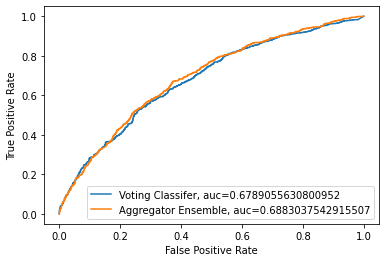

In [49]:
# ROC Curve

voting_cls_pred_proba = voting_ensemble_0.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test,  voting_cls_pred_proba, pos_label="W")
auc = roc_auc_score(y_test, voting_cls_pred_proba)
plt.plot(fpr,tpr,label="Voting Classifer, auc="+str(auc))

unsupervised_ensemble_pred_proba = ensemble_0.predict_proba(X_test).values[::,0]
fpr, tpr, _ = roc_curve(y_test, unsupervised_ensemble_pred_proba, pos_label="W")
auc = roc_auc_score(y_test, unsupervised_ensemble_pred_proba)
plt.plot(fpr,tpr,label="Aggregator Ensemble, auc="+str(auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
# plt.show()
plt.savefig("roc_curve.png")